In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score

Vamos a realizar la parte de regresión, el cual el objetivo es predecir la variable: nota_final.  
Para ello cargamos los datasets preprocesados (train y test)

In [61]:
M_train_regre = pd.read_csv("../Data/processed/M_train_regre.csv")
M_test_regre  = pd.read_csv("../Data/processed/M_test_regre.csv")
y_train_regre = pd.read_csv("../Data/processed/y_train_regre.csv")
y_test_regre  = pd.read_csv("../Data/processed/y_test_regre.csv")


In [62]:
M_train_regre.sample()

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad_Fácil,nivel_dificultad_Medio,tiene_tutor_Sí,horario_estudio_preferido_Noche,horario_estudio_preferido_Tarde,estilo_aprendizaje_Kinestésico,estilo_aprendizaje_Lectura/Escritura,estilo_aprendizaje_Visual
218,-0.722529,-0.954402,-0.62092,0.081919,0.422422,False,True,False,True,False,False,True,False


El primer modelo que probamos es la Regresión Lineal. Este modelo asume que existe una relación lineal entre las variables predictoras y la variable objetivo (`nota_final`).


In [63]:
lin_reg = LinearRegression()
lin_reg.fit(M_train_regre, y_train_regre)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [64]:
y_pred_regre = lin_reg.predict(M_test_regre)

Calcular los 3 indicadores principales:
- MAE (Error Absoluto Medio)
- RMSE (Raíz del Error Cuadrático Medio)
- R² (Coeficiente de determinación)

In [65]:
mae = mean_absolute_error(y_test_regre, y_pred_regre)
mae

5.816252914505675

In [66]:
from sklearn.metrics import mean_squared_error as mse
rmse = np.sqrt(mse(y_test_regre, y_pred_regre))
rmse

np.float64(7.228184823105237)

In [67]:
r2 = r2_score(y_test_regre, y_pred_regre)
r2

0.36128404675439774

Resultados del modelo de Regresión Lineal:

- MAE es 6: el modelo se equivoca unos 6 puntos en promedio en la predicción de la nota final  
- RMSE es 7.2: los errores más grandes pesan más, pero siguen estando en un rango razonable
- R2 es 0.36: el modelo solo explica un 36% de la variabilidad de las notas


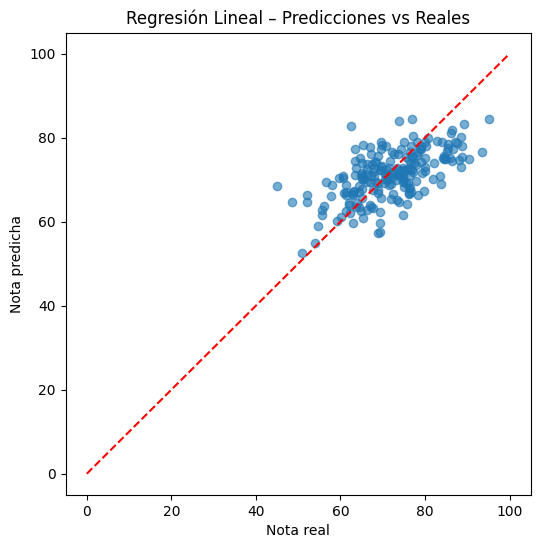

In [262]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_regre, y_pred_regre, alpha=0.6)
plt.plot([0,100],[0,100],"r--")
plt.xlabel("Nota real")
plt.ylabel("Nota predicha")
plt.title("Regresión Lineal – Predicciones vs Reales")
plt.show()


Como el modelo de Regresión Lineal no es el mejor modelo, vamos a probar con otros. A continuación, vamos a realizar un Árbol de Decisión

In [263]:
# Para ello, definimos una rejilla muy simple de profundidades a probar
depths = [2, 3, 4, 5, 6, 8, 10]
# Sirve para controlar cuantos niveles puede tener un árbol, cuantas preguntas puede hacer

In [264]:
# Usamos validación cruzada (k=5) dividiendo el conjunto de entrenamiento en 5 partes, entrenamos con 4 
# y validamos con 1, repitiendo hasta que cada parte haya sido validada una vez
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for d in depths:
    model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=10, random_state=42)
    # para la regresión usamos R^2
    scores = cross_val_score(model, M_train_regre, y_train_regre, cv=cv, scoring="r2")
    cv_results.append(scores.mean())
cv_results

[np.float64(0.18406664980872722),
 np.float64(0.2345458086197616),
 np.float64(0.2588268529505976),
 np.float64(0.24236468473859688),
 np.float64(0.19528278717895925),
 np.float64(0.16699323920575332),
 np.float64(0.14474937102755767)]

In [265]:
# Calculamos el R2 medio de cada modelo en esas 5 repeticiones y seleccionamos aquel que el error esté minimizado
best_idx = int(np.argmax(cv_results))
best_depth = depths[best_idx]
best_depth

4

In [266]:
# Con el valor del mejor valor depth, empezamos a entrenar al programa: 4
tree_reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, random_state=42)
tree_reg.fit(M_train_regre, y_train_regre)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [267]:
# ahora con los datos que separamos para text, predecimos y sacamos los errores para ver como se ajusta
y_pred_tree = tree_reg.predict(M_test_regre)
mae_tree  = mean_absolute_error(y_test_regre, y_pred_tree)
mae_tree

6.430588286171488

In [268]:
rmse_tree = np.sqrt(mean_squared_error(y_test_regre, y_pred_tree))
rmse_tree

np.float64(7.902613642402014)

In [269]:
r2_tree   = r2_score(y_test_regre, y_pred_tree)
r2_tree

0.23653212836762472

- MAE tiene un error de 8.7: error promedio más alto que la regresión lineal
- RMSE es de 11.0: errores bastante grandes todavía
- R2 es de -0.48: un valor negativo significa que el árbol predice peor que simplemente usar la media de las notas-

Como no nos ha dado el árbol sin límites un ajuste mejor que la regresión lineal, a continuación vamos a probar con un árbol con restricciones

In [270]:
tree_reg_final = DecisionTreeRegressor(
    max_depth=best_depth, 
    min_samples_leaf=10, 
    random_state=42)
tree_reg_final.fit(M_train_regre, y_train_regre)

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [271]:
y_pred_tree_final = tree_reg_final.predict(M_test_regre)

In [272]:
mae_tree  = mean_absolute_error(y_test_regre, y_pred_tree_final)
mae_tree

6.430588286171488

In [273]:
rmse_tree = np.sqrt(mean_squared_error(y_test_regre, y_pred_tree_final))
rmse_tree

np.float64(7.902613642402014)

In [274]:
r2_tree   = r2_score(y_test_regre, y_pred_tree_final)
r2_tree

0.23653212836762472

### Conclusiones de la parte de Regresión

- Regresión Lineal:  
  - MAE ≈ 5.8  
  - RMSE ≈ 7.2  
  - R² ≈ 0.36  
  La regresión lineal logra capturar parte de la variabilidad de las notas, con errores medios de unos 6-7 puntos

- Árbol de Decisión regulado (profundidad=4):  
  - MAE ≈ 6.4  
  - RMSE ≈ 7.9  
  - R² ≈ 0.24  
  Aunque el árbol regulado es mejor que un árbol sin límites, sigue siendo peor que la regresión lineal 

- La regresión lineal es el modelo más adecuado para la regresión.

CLASIFICACIÓN con regresión logística

In [275]:
# Ahora usamos la variable 'aprobado' como target (0=suspenso, 1=aprobado)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [276]:
# cargamos los datos de clasificación (los que guardamos en "processed")
M_train_clasif = pd.read_csv("../Data/processed/M_train_clasif.csv")
M_test_clasif  = pd.read_csv("../Data/processed/M_test_clasif.csv")
y_train_clasif = pd.read_csv("../Data/processed/y_train_clasif.csv")
y_test_clasif  = pd.read_csv("../Data/processed/y_test_clasif.csv")

In [277]:
#Comprobamos que la tabla no tenga la columna aprobado
M_train_clasif.sample()

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad_Fácil,nivel_dificultad_Medio,tiene_tutor_Sí,horario_estudio_preferido_Noche,horario_estudio_preferido_Tarde,estilo_aprendizaje_Kinestésico,estilo_aprendizaje_Lectura/Escritura,estilo_aprendizaje_Visual
550,1.088986,-0.787367,-0.678538,-0.133302,-0.728592,False,True,True,True,False,False,False,True


In [278]:
# entrenamos el modelo
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(M_train_clasif, y_train_clasif)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [279]:
# hacemos predicciones
y_pred_log = log_clf.predict(M_test_clasif)
y_proba_log = log_clf.predict_proba(M_test_clasif)[:,1]

In [280]:
acc_log = accuracy_score(y_test_clasif, y_pred_log)
acc_log

0.905

In [281]:
prec_log = precision_score(y_test_clasif, y_pred_log)
prec_log

0.9128205128205128

In [282]:
rec_log = recall_score(y_test_clasif, y_pred_log)
rec_log

0.9888888888888889

In [283]:
f1_log = f1_score(y_test_clasif, y_pred_log)
f1_log

0.9493333333333334

In [284]:
roc_auc_log = roc_auc_score(y_test_clasif, y_proba_log)
roc_auc_log

0.8094444444444444

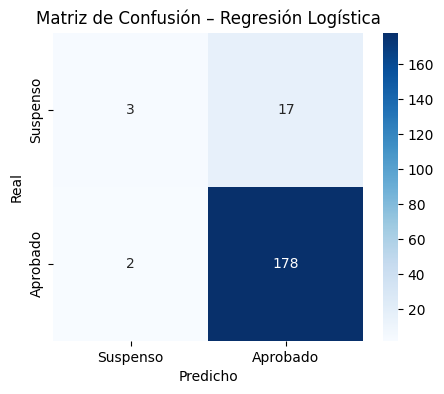

In [303]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_clasif, y_pred_log)  # para logística (puedes repetir con el árbol)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Suspenso","Aprobado"], yticklabels=["Suspenso","Aprobado"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión – Regresión Logística")
plt.show()


### Resultados Regresión Logística
- Accuracy ≈ 0.91  
- Precision ≈ 0.91  
- Recall ≈ 0.99  
- F1 ≈ 0.95  
- ROC-AUC ≈ 0.81  
El modelo de regresión logística consigue muy buen rendimiento. Esto la convierte en una muy buena opción como modelo base de clasificación.  


### Árbol de Clasificación Básico: 
Probamos un árbol porque captura relaciones no lineales y es fácil de interpretar.
Primero entreno uno básico, luego busco una profundidad (`max_depth`) razonable con validación cruzada
y al final comparo con la regresión logística.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(M_train_clasif, y_train_clasif)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
y_pred_tree = tree_clf.predict(M_test_clasif)
y_prob_tree = tree_clf.predict_proba(M_test_clasif)[:, 1]

In [ ]:
acc_tree  = accuracy_score(y_test_clasif, y_pred_tree)
acc_tree

0.85

In [ ]:
prec_tree = precision_score(y_test_clasif, y_pred_tree)
prec_tree

0.9213483146067416

In [ ]:
rec_tree  = recall_score(y_test_clasif, y_pred_tree)
rec_tree

0.9111111111111111

In [ ]:
f1_tree   = f1_score(y_test_clasif, y_pred_tree)
f1_tree

0.9162011173184358

In [ ]:
auc_tree  = roc_auc_score(y_test_clasif, y_prob_tree)
auc_tree

0.6055555555555556

In [ ]:
cm_tree   = confusion_matrix(y_test_clasif, y_pred_tree)
cm_tree

array([[  6,  14],
       [ 16, 164]])

- 6 suspensos bien clasificados, 14 suspensos mal (dijo que aprobaban)
- 164 aprobados bien, 16 aprobados mal (dijo que suspendían)

A continuación ajustamos depth

In [ ]:
depths = [2, 3, 4, 5, 6, 8, 10]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mean = []
for d in depths:
    m = DecisionTreeClassifier(max_depth=d, min_samples_leaf=10, random_state=42)
    scores = cross_val_score(m, M_train_clasif, y_train_clasif, cv=cv, scoring="accuracy")
    cv_mean.append(scores.mean())
    # probamos varias profundidades para ver cuál es mejor con validación cruzada
    print(f"prof={d} -> accuracy medio: {scores.mean():.3f}")
best_depth = depths[int(np.argmax(cv_mean))]
best_depth


prof=2 -> accuracy medio: 0.884
prof=3 -> accuracy medio: 0.886
prof=4 -> accuracy medio: 0.891
prof=5 -> accuracy medio: 0.889
prof=6 -> accuracy medio: 0.887
prof=8 -> accuracy medio: 0.875
prof=10 -> accuracy medio: 0.871


4

In [ ]:
# Árbol final con la mejor profundidad
tree_final = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=10, random_state=42)
tree_final.fit(M_train_clasif, y_train_clasif)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
y_pred_tree_final = tree_final.predict(M_test_clasif)
y_prob_tree_final = tree_final.predict_proba(M_test_clasif)[:, 1]

In [ ]:
acc_t  = accuracy_score(y_test_clasif, y_pred_tree_final)
acc_t

0.91

In [ ]:
prec_t = precision_score(y_test_clasif, y_pred_tree_final)
prec_t

0.9090909090909091

In [ ]:
rec_t  = recall_score(y_test_clasif, y_pred_tree_final)
rec_t

1.0

In [ ]:
f1_t   = f1_score(y_test_clasif, y_pred_tree_final)
f1_t

0.9523809523809523

In [ ]:
auc_t  = roc_auc_score(y_test_clasif, y_prob_tree_final)
auc_t

0.7148611111111112

### Conclusión Clasificación

- La **regresión logística** funciona muy bien, con buenas métricas y es fácil de usar.  
- El **árbol de decisión** con profundidad 4 mejora bastante respecto al árbol básico y da resultados parecidos a la logística.  

En general, me quedo con la regresión logística como modelo principal porque es más estable,  
aunque el árbol también es útil para ver qué variables influyen más en el aprobado.


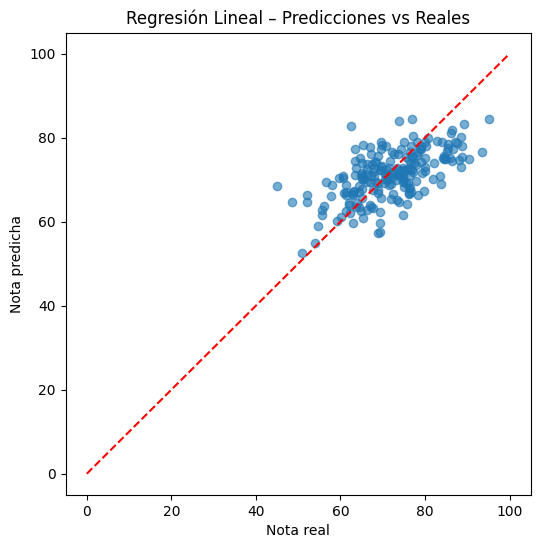

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_regre, y_pred_regre, alpha=0.6)
plt.plot([0,100],[0,100],"r--")
plt.xlabel("Nota real")
plt.ylabel("Nota predicha")
plt.title("Regresión Lineal – Predicciones vs Reales")
plt.show()
